## TuriCreate Busyness Classifier

In [1]:
from model_metrics import *
from preprocessing import *
from crossvalidation import *
from helpers import *
from matplotlib_styles import *

In [2]:
import turicreate as tc
import shutil

In [3]:
start_time = datetime.now()
print(f"NOTEBOOK START TIME: {start_time.strftime('%H:%M:%S')}")

NOTEBOOK START TIME: 12:27:17


---

In [4]:
BASE_MODEL = "resnet-50"
augmentation = False
preprocessing = True
final = False

CONFIG_STR = BASE_MODEL + "_P" + str(preprocessing) + "_A" + str(augmentation) + "_"

tc.data_structures.serialization.enable_sframe_serialization("./sframe_serialization/")

In [5]:
print(f"CONFIG")
print("----------------------------------------")
print(f"model:                 {BASE_MODEL}"
      f"\naugmentation:          {augmentation}"
      f"\npreprocessing:         {preprocessing}"
      f"\nfinal:                 {final}")
print("----------------------------------------\n")


CONFIG
----------------------------------------
model:                 resnet-50
augmentation:          False
preprocessing:         True
final:                 False
----------------------------------------



### Data Preparation and Preprocessing

In [6]:
DIR_RAW = "datasets/crossval/raw/"
DIR_AUG = "datasets/crossval/augmented/"
DIR_PRE = "datasets/crossval/preprocessed/"

In [7]:
shutil.rmtree(DIR_AUG)
shutil.rmtree(DIR_PRE)

In [8]:
if augmentation:
    os.makedirs(DIR_AUG + "busy")
    os.makedirs(DIR_AUG + "not_busy")

    apply_augmentation(DIR_RAW + "busy/", DIR_AUG + "busy/")
    apply_augmentation(DIR_RAW + "not_busy/", DIR_AUG + "not_busy/")
    print("DONE AUGMENTATION")
else:
    shutil.copytree(DIR_RAW + "busy/", DIR_AUG + "busy/")
    shutil.copytree(DIR_RAW + "not_busy/", DIR_AUG + "not_busy/")

if preprocessing:
    os.makedirs(DIR_PRE + "busy")
    os.makedirs(DIR_PRE + "not_busy")

    apply_preprocessing(DIR_AUG + "busy/", DIR_PRE + "busy/")
    apply_preprocessing(DIR_AUG + "not_busy/", DIR_PRE + "not_busy/")
    print("DONE PREPROCESSING")
else:
    shutil.copytree(DIR_AUG + "busy/", DIR_PRE + "busy/")
    shutil.copytree(DIR_AUG + "not_busy/", DIR_PRE + "not_busy/")


DONE PREPROCESSING


In [9]:
# DATA SETUP
raw_data = tc.image_analysis.load_images(DIR_RAW, with_path=True)
raw_data["label"] = raw_data["path"].apply(lambda path: "busy" if "/busy" in path else "not_busy")
raw_data.save("./sframes/crossavl_raw.sframe")
# raw_data.show()

In [10]:
preprocessed_data = tc.image_analysis.load_images(DIR_PRE, with_path=True)
preprocessed_data["label"] = preprocessed_data["path"].apply(lambda path: "busy" if "/busy" in path else "not_busy")
preprocessed_data.save("./sframes/crossval_preprocessed.sframe")
# preprocessed_data.show()

In [11]:
# images = data["image"]
# deep_features = tc.image_analysis.get_deep_features(data["image"], model_name)

### K-Fold Cross Validation

In [12]:
cv10_metrics = load_pickle(CONFIG_STR + "cv10_metrics")
if cv10_metrics is None:
    cv10 = crossval_classic(preprocessed_data, 10, BASE_MODEL)
    cv10_metrics = get_model_metrics(cv10)
    dump_pickle(cv10_metrics, CONFIG_STR + "cv10_metrics")

1
training locations: []   sample size: 900
testing locations: []   sample size: 100
accuracy: 0.93, precision: 0.92, recall: 0.94, f1: 0.93, log loss: 0.17
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     busy     |       busy      |   46  |
|   not_busy   |       busy      |   3   |
|   not_busy   |     not_busy    |   47  |
|     busy     |     not_busy    |   4   |
+--------------+-----------------+-------+
[4 rows x 3 columns]


2
training locations: []   sample size: 900
testing locations: []   sample size: 100
accuracy: 0.95, precision: 0.94, recall: 0.96, f1: 0.95, log loss: 0.14
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     busy     |       busy      |   46  |
|   not_busy   |       busy      |   2   |
|   not_busy   |     not_busy    |   49  |
|     busy     |     not_busy    |   3   |
+--------------+--

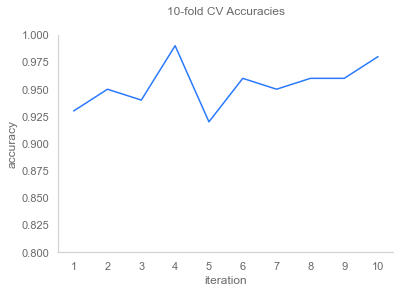

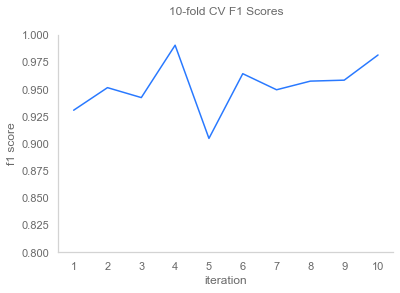

In [13]:
print_metrics(cv10_metrics)

accuracies = [metrics.accuracy for metrics in cv10_metrics]
f1s = [metrics.f1 for metrics in cv10_metrics]

print(f"average accuracy: {sum(accuracies) / len(cv10_metrics)}")
print(f"average f1: {sum(f1s) / len(cv10_metrics)}")
print("----------------------------------------\n")

plot_line(range(1, len(accuracies) + 1), accuracies, "iteration", "accuracy", ymin=0.8, title="10-fold CV Accuracies")
plot_line(range(1, len(f1s) + 1), f1s, "iteration", "f1 score", ymin=0.8, title="10-fold CV F1 Scores")

In [14]:
# for i in range(len(cv_classic)):
#     plot_roc(cv_classic[i].metrics.roc_curve, title=f"ROC 10-fold CV Fold {i + 1}")

In [15]:
# avg_accs = [sum(accuracies) / len(cv10_metrics)]
# avg_f1s = [sum(f1s) / len(cv10_metrics)]
#
# for k in [5, 4, 2]:
#     cvk_metrics = load_pickle(CONFIG_STR + f"cv{k}_metrics")
#     if cvk_metrics is None:
#         cvk = crossval_classic(preprocessed_data, k, BASE_MODEL)
#         cvk_metrics = get_model_metrics(cvk)
#         dump_pickle(cvk_metrics, CONFIG_STR + f"cv{k}_metrics")
#     avg_acc = sum([metrics.accuracy for metrics in cvk_metrics]) / len(cvk_metrics)
#     avg_f1 = sum([metrics.f1 for metrics in cvk_metrics]) / len(cvk_metrics)
#     avg_accs.insert(0, avg_acc)
#     avg_f1s.insert(0, avg_f1)

In [16]:
# plot_line([2, 4, 5, 10], avg_accs, "k", "average accuracy", ymin=0.6, title="k-fold CV Avg "
#                                                                                         "Accuracies")
# plot_line([2, 4, 5, 10], avg_f1s, "k", "average f1 score", ymin=0.6, title="k-fold CV Avg F1 "
#                                                                                        "Scores")

### Location-based Cross Validation

In [17]:
locations = ["OxfordCircus", "DaviesSt", "VereSt", "RegentSt", "StGiles"]

In [18]:
cvlocs_metrics = load_pickle(CONFIG_STR + "cvlocs_metrics")
if cvlocs_metrics is None:
    cvloc1 = crossval_location(preprocessed_data, locations, 1, 200, 200, BASE_MODEL)
    cvloc2 = crossval_location(preprocessed_data, locations, 2, 400, 200, BASE_MODEL)
    cvloc3 = crossval_location(preprocessed_data, locations, 3, 600, 200, BASE_MODEL)
    cvloc4 = crossval_location(preprocessed_data, locations, 4, 800, 200, BASE_MODEL)

    cvlocs = [cvloc1, cvloc2, cvloc3, cvloc4]

    cvlocs_metrics = [get_model_metrics(cv) for cv in cvlocs]

    dump_pickle(cvlocs_metrics, CONFIG_STR + "cvlocs_metrics")

----------------------------------------
200 TRAINING LOCATIONS

1
training locations: ['OxfordCircus']   sample size: 200
testing locations: ['VereSt', 'DaviesSt', 'StGiles', 'RegentSt']   sample size: 200
accuracy: 0.73, precision: 0.87, recall: 0.58, f1: 0.7, log loss: 0.8
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     busy     |     not_busy    |   9   |
|     busy     |       busy      |   86  |
|   not_busy   |       busy      |   44  |
|   not_busy   |     not_busy    |   61  |
+--------------+-----------------+-------+
[4 rows x 3 columns]


2
training locations: ['DaviesSt']   sample size: 200
testing locations: ['VereSt', 'StGiles', 'RegentSt', 'OxfordCircus']   sample size: 200
accuracy: 0.68, precision: 0.71, recall: 0.64, f1: 0.67, log loss: 3.15
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|     busy   

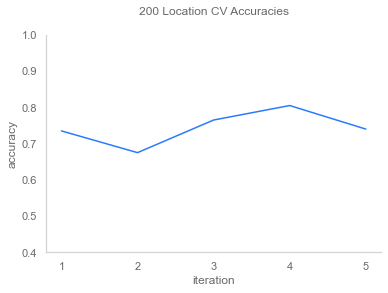

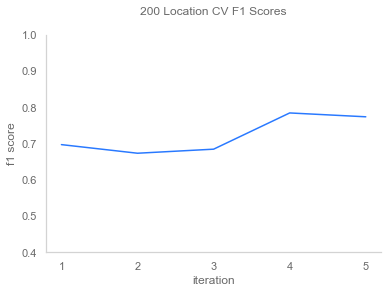

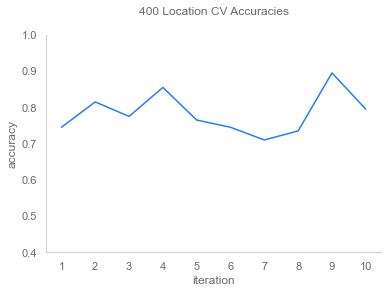

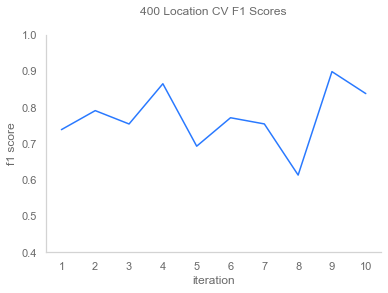

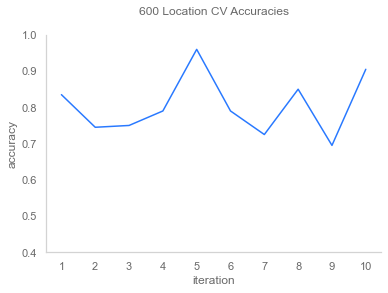

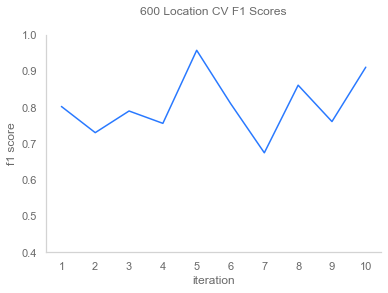

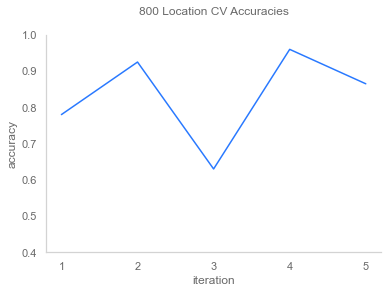

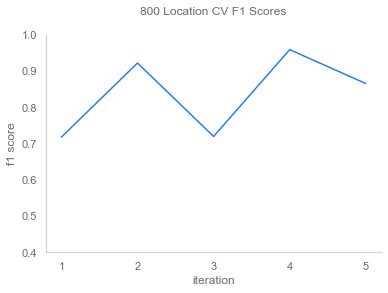

In [19]:
for cvloc_metrics in cvlocs_metrics:
    print("----------------------------------------")
    print(f"{cvloc_metrics[0].train_size} TRAINING LOCATIONS\n")
    accuracies = [metrics.accuracy for metrics in cvloc_metrics]
    f1s = [metrics.f1 for metrics in cvloc_metrics]

    print_metrics(cvloc_metrics)
    print(f"{cvloc_metrics[0].train_size} TRAINING LOCATION SUMMARY")
    print(f"average accuracy: {sum(accuracies) / len(cvloc_metrics)}")
    print(f"average f1: {sum(f1s) / len(cvloc_metrics)}")
    print("\n----------------------------------------\n\n")

    plot_line(range(1, len(accuracies) + 1), accuracies, "iteration", "accuracy", ymin=0.4, title=f"{cvloc_metrics[0].train_size} Location CV "
                                                                                                  "Accuracies")
    plot_line(range(1, len(accuracies) + 1), f1s, "iteration", "f1 score", ymin=0.4, title=f"{cvloc_metrics[0].train_size} Location CV F1 "
                                                                                           "Scores")
    # for cv in cvl:
    #     plot_roc(cv.metrics.roc_curve, title=f"ROC Location-based CV\nTraining Locations {cv.metrics.train_locs}")

In [20]:
avg_accs = []
avg_f1s = []
for cvloc_metrics in cvlocs_metrics:
    avg_acc = sum([metrics.accuracy for metrics in cvloc_metrics]) / len(cvloc_metrics)
    avg_f1 = sum([metrics.f1 for metrics in cvloc_metrics]) / len(cvloc_metrics)
    avg_accs.append(avg_acc)
    avg_f1s.append(avg_f1)

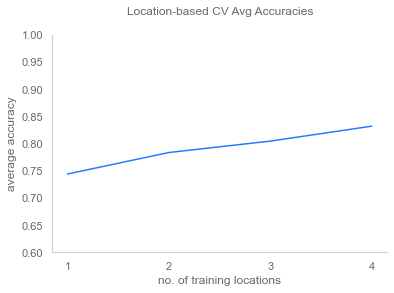

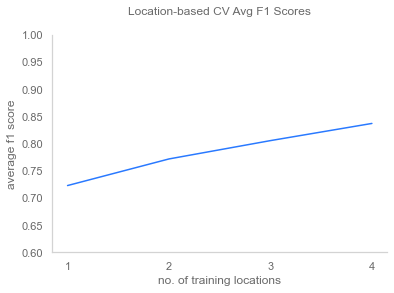

In [21]:
plot_line(range(1, 5), avg_accs, "no. of training locations", "average accuracy", ymin=0.6, title="Location-based CV " \
                                                                                                 "Avg "
                                                                                        "Accuracies")
plot_line(range(1, 5), avg_f1s, "no. of training locations", "average f1 score", ymin=0.6, title="Location-based CV " \
                                                                                                "Avg F1 "
                                                                                       "Scores")

#### 4-Location Cross Validation Varying Training Set Size

In [22]:
# n_training_locations = 4
# training_sizes = range(100, 900, 100)
# testing_size = 200
#
# cvls = []
# for training_size in training_sizes:
#     cvl = crossval_location(preprocessed_data, locations, n_training_locations, training_size, testing_size, BASE_MODEL)
#     cvls.append(cvl)

In [23]:
# for cvl in cvls:
#     print_metrics([model.metrics for model in cvl])

In [24]:
# avg_accs = []
# avg_f1s = []
# for cvl in cvls:
#     avg_acc = sum(list(map(lambda model: model.metrics.accuracy, cvl))) / len(cvl)
#     avg_f1 = sum(list(map(lambda model: model.metrics.f1, cvl))) / len(cvl)
#     avg_accs.append(avg_acc)
#     avg_f1s.append(avg_f1)

In [25]:
# print("4 training locations, 200 testing images")
# plot_line(training_sizes, avg_accs, "no. of training images", "average accuracy", ymin=0.7, title="4-location CV Avg "
#                                                                                         "Accuracies")
# plot_line(training_sizes, avg_f1s, "no. of training images", "average f1 score", ymin=0.7, title="4-location CV Avg "
#                                                                                                  "F1 Scores")

In [26]:
# best_models = []
# for cvl in cv_locs:
#     best_model = max(cvl, key=attrgetter("metrics.f1"))
#     best_models.append(best_model)
#
# print("BEST MODELS PER CV")
# for model in best_models:
#     model.metrics.display()
# print("----------------------------------------\n\n")
# print("BEST MODEL")
# best_model = max(best_models, key=attrgetter("metrics.f1"))
# best_model.metrics.display()

In [27]:
if final:
    # shuffled = preprocessed_data.copy().shuffle()
    # test_data = shuffled[:len(shuffled) / 5]
    # train_data = shuffled.filter_by(filter(lambda path: path not in test_data["path"], shuffled["path"]), "path")

    final_model = tc.image_classifier.create(preprocessed_data.copy(),
                                                    target="label",
                                                    model=BASE_MODEL,
                                                    seed=42,
                                                    verbose=False)
    # evaluation = final_model.evaluate(test_data)
    # metrics = Metrics(train_size=len(train_data), test_size=len(test_data), metrics=evaluation)
    # metrics.display()

    final_model.export_coreml(f"./mlmodels/{BASE_MODEL}.mlmodel")

---

In [28]:
end_time = datetime.now()
print(f"NOTEBOOK END TIME: {end_time.strftime('%H:%M:%S')}")
print(f"TOTAL RUNTIME: {end_time - start_time}")

NOTEBOOK END TIME: 12:27:26
TOTAL RUNTIME: 0:00:09.349487
